# Concept2Sentence Transformations

*   in_text --> concepts --> out_text
*   in_text --> concepts --> antonym_swap --> out_text
*   [in_text] --> [concepts] --> [out_text]



In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import numpy as np
import pke
import random
import itertools
import string
 
import torch
 
from datasets import load_dataset
from transformers import (
    AutoModel,
    AutoTokenizer,
    AutoModelForSeq2SeqLM, 
    Seq2SeqTrainer, 
    Seq2SeqTrainingArguments,
    AutoModelForSequenceClassification,
)
from huggingface_hub import HfApi
from transformers_interpret import SequenceClassificationExplainer

from sibyl import *
 
api = HfApi()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fabrice\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fabrice\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Extract Concepts

In [3]:
def extract_ngrams(in_text, 
                   grams=3, 
                   return_lesser_grams=True, 
                   remove_stopwords=True):
  
    stops = []
    if remove_stopwords:
        stops = stopwords.words('english')
        stops.remove('not')

    def _get_ngram_phrases(in_text, gram):
        all_grams = []
        n_out = ngrams(in_text.split(), gram)
        for out in n_out:
            # if not all([w in stops for w in out]):
            if sum([w not in stops for w in out]) / len(out) > 0.5:
                out = ' '.join(list(out))
                all_grams.append(out) 
        return all_grams
    
    #strip punctuation
    in_text = in_text.translate(str.maketrans('', '', string.punctuation))

    if return_lesser_grams:
        all_grams = []
        for gram in range(1,grams+1):
            all_grams.extend(_get_ngram_phrases(in_text, gram))
    else:
        all_grams = _get_ngram_phrases(in_text, grams)
    return [all_grams]

def extract_keyphrases(in_text, n=None):
    if n is None:
        n = random.randint(2,5)
 
    # extract key phrases
    pos = {'NOUN', 'PROPN', 'ADJ', 'VERB'}
    extractor = pke.unsupervised.TopicRank()
    extractor.load_document(input=in_text, language='en')
    extractor.candidate_selection(pos=pos)
    extractor.candidate_weighting()
    keyphrases = extractor.get_n_best(n=n)
    keyphrases = [p[0] for p in keyphrases]
    return [keyphrases]
 
def extract_concepts(in_text, n=None):
    if n is None:
        n = random.randint(2,5)
 
    # extract key phrases
    keyphrases = extract_keyphrases(in_text, n)[0]
 
    # distill phrases to concepts
    concepts = set([kp if len(kp.split()) == 1 
                    else random.sample(kp.split(),1)[0] for kp in keyphrases])
    return [list(concepts)]

def merge_bpe(tok, boe, chars="##"):
    len_chars = len(chars)

    new_tok = []
    new_boe = []

    emb = []
    append = ""
    for t, e in zip(tok[::-1], boe[::-1]):
        t += append
        emb.append(e)
        if t.startswith(chars):
            append = t[len_chars:]
        else:
            append = ""
            new_tok.append(t)
            new_boe.append(np.stack(emb).mean(axis=0))
            emb = []  
    new_tok = np.array(new_tok)[::-1]
    new_boe = np.array(new_boe)[::-1]
    return new_tok, new_boe

# Concept --> Sentence

In [4]:
MIN_GENERATION_LENGTH = 10
MAX_GENERATION_LENGTH = 32
BEAM_SIZE = 5

In [5]:
def scale(out, rmax=1, rmin=0):
    output_std = (out - out.min()) / (out.max() - out.min())
    output_scaled = output_std * (rmax - rmin) + rmin
    return output_scaled

In [6]:
def construct_input_for_batch(batch):
    """
    Function that takes a batch from a dataset and constructs the corresponding
    input string.
    """
    source = [' '.join(concepts) for concepts in batch["concepts"]]
    target = batch["target"]
    return source, target
 
def make_batch_inputs(batch, tokenizer, device='cuda:0'):
    """
    Function that takes a batch from a dataset and formats it as input to model.
    """
    # Concatenate the concept names for each example in the batch.
    input_lists, _ = construct_input_for_batch(batch)
    # Use the model's tokenizer to create the batch input_ids.
    batch_features = tokenizer(input_lists, padding=True, return_tensors='pt')
    # Move all inputs to the device.
    batch_features = dict([(k, v.to(device)) for k, v in batch_features.items()])
    return batch_features
 
def batch_tokenize(dataset_batch, tokenizer, decoder_max_length=32):
    """
    Construct the batch (source, target) and run them through a tokenizer.
    """
    source, target = construct_input_for_batch(dataset_batch)
    res = {
        "input_ids": tokenizer(source)["input_ids"],
        "labels": tokenizer(
            target,
            padding='max_length',
            truncation=True,
            max_length=decoder_max_length
        )["input_ids"],
    }
    return res
 
def beam_generate_sentences(batch,
                            model,
                            tokenizer,
                            num_beams=4,
                            min_length=10,
                            max_length=32,
                            device='cuda:0'):
    """
    Function to generate outputs from a model with beam search decoding.
    """
    # Create batch inputs.
    features = make_batch_inputs(
        batch=batch,
        tokenizer=tokenizer,
        device=device)
    
    # Generate with beam search.
    generated_ids = model.generate(
        input_ids=features['input_ids'],
        attention_mask=features['attention_mask'],
        num_beams=num_beams,
        min_length=min_length,
        max_length=max_length,
    )
    # Use model tokenizer to decode to text.
    generated_sentences = [
        tokenizer.decode(gen_ids.tolist(), skip_special_tokens=True)
        for gen_ids in generated_ids
    ]
    return generated_sentences

def visualize_salience(in_text, target, dataset):
    modelIds = api.list_models(filter=("pytorch", "dataset:" + dataset), sort='downloads', direction=-1)
    if modelIds:
        modelId = getattr(modelIds[0], 'modelId')
        print('Using ' + modelId + ' to rationalize keyphrase selections.')

    interp_model = AutoModelForSequenceClassification.from_pretrained(modelId).to(device)
    interp_tokenizer = AutoTokenizer.from_pretrained(modelId)

    cls_explainer = SequenceClassificationExplainer(interp_model, interp_tokenizer)
    attributions = cls_explainer(in_text, target)
    print(cls_explainer.predicted_class_name)
    cls_explainer.visualize()
    return attributions

import numpy as np

def one_hot_encode(y, nb_classes):
    if isinstance(y, np.ndarray):
        if len(y.shape) == 1:
            y = np.expand_dims(y, 0)
    else:
        y = np.expand_dims(np.array(y), 0)
    if y.shape[-1] == nb_classes:
        return y
    res = np.eye(nb_classes)[y.reshape(-1)]
    return res.reshape(list(y.shape)+[nb_classes]).squeeze()

def soften_label(y, num_classes=None):
    if not num_classes:
        if isinstance(y, int):
            num_classes = max(2, y + 1)
        elif isinstance(y, list):
            num_classes = len(y)
        elif isinstance(y, np.ndarray):
            if len(y.shape) == 1:
                num_classes = len(y)
            else:
                num_classes = y.shape[-1]
    return one_hot_encode(y, num_classes) 

def invert_label(y, soften=False, num_classes=None):
    if not isinstance(y, np.ndarray):
        y = soften_label(y, num_classes)
    y = y[::-1]
    if not soften:
        y = np.argmax(y)
    return y

def interpolate_label(y1, y2, x1=None, x2=None, num_classes=None, y_weights=None):
    if isinstance(y_weights, (list, tuple)):
        mass_y1 = y_weights[0]
        mass_y2 = y_weights[1]
    elif x1 and x2:
        mass_y1 = len(x1) / (len(x1) + len(x2)) 
        mass_y2 = 1 - mass_y1
    else:
        mass_y1 = 1
        mass_y2 = 1    
    y1 = soften_label(y1, num_classes) * mass_y1
    y2 = soften_label(y2, num_classes) * mass_y2
    return (y1 + y2) / (y1 + y2).sum()

def weight_label(y, y_weights=None):
    if not y_weights:
        y_weights = np.ones_like(y)
    y = y * np.array(y_weights)
    return y / y.sum()

def smooth_label(y, factor=0.1):
    if not isinstance(y, np.ndarray):
        y = soften_label(y)
    y = y * (1. - factor)
    y = y + (factor / y.shape[-1])
    return y

In [7]:
tokenizer = AutoTokenizer.from_pretrained("sibyl/BART-commongen")
model = AutoModelForSeq2SeqLM.from_pretrained("sibyl/BART-commongen").to(device)

In [8]:
num_concepts = random.randint(2,5)
test_sentence = 'frenetic but not really funny' # 'both deeply weird and charmingly dear' # 'frenetic but not really funny'
grams = extract_ngrams(test_sentence, grams=3, return_lesser_grams=False)
grams_all = extract_ngrams(test_sentence, grams=3, return_lesser_grams=True)
keyphrases = extract_keyphrases(test_sentence, n=num_concepts)
concepts = extract_concepts(test_sentence, n=num_concepts)
grams, grams_all, keyphrases, concepts

([['frenetic but not', 'but not really', 'not really funny']],
 [['frenetic',
   'not',
   'really',
   'funny',
   'not really',
   'really funny',
   'frenetic but not',
   'but not really',
   'not really funny']],
 [['frenetic', 'funny']],
 [['funny', 'frenetic']])

In [9]:
batch = {'concepts': concepts, 'target': ''}

sentence = beam_generate_sentences(
    batch,
    model,
    tokenizer,
    num_beams=BEAM_SIZE,
    min_length=MIN_GENERATION_LENGTH,
    max_length=MAX_GENERATION_LENGTH,
    device=device
)

batch, sentence

({'concepts': [['funny', 'frenetic']], 'target': ''},
 ['A young man is having fun with his frenetic friends.'])

In [21]:
class RationalizedKeyphraseExtractor:
    def __init__(self, 
                 dataset=None, 
                 device='cpu', 
                 extract='tokens',
                 remove_stopwords=False):
      
        self.dataset = dataset
        self.device = device
        self.extract = extract
        self.remove_stopwords = remove_stopwords
        self.model = None
        self.tokenizer = None
        self.interpreter = None

        if dataset is not None:
            api = HfApi()
            # find huggingface model to provide rationalized output
#             modelIds = api.list_models(filter=("pytorch", "dataset:" + dataset), 
#                                        sort='downloads', 
#                                        direction=-1)
            modelIds = api.list_models(filter=("pytorch", "dataset:" + dataset))
            if modelIds:
                modelId = getattr(modelIds[0], 'modelId')
                print('Using ' + modelId + ' to rationalize keyphrase selections.')
                self.model = AutoModelForSequenceClassification.from_pretrained(modelId).to(self.device)
                self.tokenizer = AutoTokenizer.from_pretrained(modelId)
                self.interpreter = SequenceClassificationExplainer(self.model, self.tokenizer)
            else:
                print('No model found to provide rationalizations. \
                       Returning standard keyphrases instead.')
        else:
            print('No dataset name provided. Returning standard keyphrases.')
        self.stops = stopwords.words('english') if self.remove_stopwords else []

    def __call__(self, in_text, label_idx=None, n=None, threshold=None):        
        if n is None:
            n = random.randint(2,5)

        if 'keyphrase' in self.extract:
            keyphrases = extract_keyphrases(in_text, n=10)[0]
        elif 'ngram' in self.extract:
            keyphrases = extract_ngrams(in_text, 
                            remove_stopwords=self.remove_stopwords)[0]
        elif 'concept' in self.extract:
            keyphrases = extract_concepts(in_text, n=10)[0]
        elif 'token' in self.extract:
            keyphrases = word_tokenize(in_text)
        else:
            keyphrases = in_text.split()
    
        if self.interpreter is not None: 
            attributions = self.interpreter(text=in_text, index=label_idx)
            tokens, weights = zip(*attributions)
            words, weights = merge_bpe(tokens, weights)
            if threshold is not None: 
                weights = scale(torch.from_numpy(np.array(weights).copy())).tolist()
            attributions = list(zip(words, weights))

            keyphrase_attributions = []
            for keyphrase in keyphrases:
                keyphrase_weight = 0
                keyphrase_tokens = keyphrase.split()
                for token in keyphrase_tokens:
                    for attr_pair in attributions:
                        attr, weight = attr_pair
                        if token.lower() == attr.lower() and token.lower() not in self.stops:
                            keyphrase_weight += weight 
                keyphrase_attributions.append((keyphrase, keyphrase_weight / len(keyphrase_tokens)))
            keyphrase_attributions.sort(key = lambda x: x[-1], reverse=True) 
            if threshold is not None:
                return list(set([x[0].lower() for x in keyphrase_attributions if x[1] >= threshold]))
            return list(set([k[0].lower() for k in keyphrase_attributions[:n]]))
        return list(set([x.lower() for x in keyphrases[:n]]))

In [22]:
class Concept2Sentence:
    def __init__(self, 
                 dataset=None, 
                 gen_beam_size=10,
                 text_min_length=10,
                 text_max_length=32,
                 device='cpu',
                 return_concepts=False):
      
        self.extractor = RationalizedKeyphraseExtractor(dataset=dataset)
        self.gen_beam_size = gen_beam_size
        self.text_min_length = text_min_length
        self.text_max_length = text_max_length
        self.device = device
        self.return_concepts = return_concepts
        self.tokenizer = AutoTokenizer.from_pretrained("sibyl/BART-commongen")
        self.model = AutoModelForSeq2SeqLM.from_pretrained("sibyl/BART-commongen").to(device)
    
    def __call__(self, batch, n=None, threshold=0.5, antonymize=False):
        in_text, in_target = batch
        # extract concepts
        concepts = self.extractor(in_text, in_target, threshold=threshold)
        if antonymize:
            antonymizer = ChangeAntonym()
            concepts = list(set([antonymizer(c) for c in concepts]))
        # reomve punctuation
        concepts = [c for c in concepts if c not in string.punctuation]
        # prepare batch --> generate sentence from concepts
        tran_batch = {'concepts': [concepts], 'target': ''}
        new_sentence = beam_generate_sentences(
            tran_batch,
            self.model,
            self.tokenizer,
            num_beams=self.gen_beam_size,
            min_length=self.text_min_length,
            max_length=self.text_max_length,
            device=self.device
        )
        if self.return_concepts:
            return concepts, new_sentence
        return new_sentence

In [23]:
rkpe = RationalizedKeyphraseExtractor(dataset='sst-2', remove_stopwords=False)
concepts = [rkpe(test_sentence, 0, threshold=0.5)]

batch = {'concepts': concepts, 'target': ''}

sentence = beam_generate_sentences(
    batch,
    model,
    tokenizer,
    num_beams=BEAM_SIZE,
    min_length=MIN_GENERATION_LENGTH,
    max_length=MAX_GENERATION_LENGTH,
    device=device
)

batch, sentence

Using distilbert-base-uncased-finetuned-sst-2-english to rationalize keyphrase selections.


({'concepts': [['funny', 'not', 'but', 'frenetic']], 'target': ''},
 ['fans are not but frenetic but funny.'])

In [ ]:
dataset = load_dataset('glue', 'sst2')
c2s = Concept2Sentence(dataset='sst-2', device=device, return_concepts=True)
def transform_dataset(dataset_batch, dataset, tran_prob=0.5, n=None, threshold=None, antonymize=False):
    transformed = False
    text, label = dataset_batch['sentence'], dataset_batch['label']
    if tran_prob > random.uniform(0, 1):
        concepts, text = c2s((text, label), n=n, threshold=threshold, antonymize=antonymize)
        transformed = True
    res = {
        "sentence": text[0] if isinstance(text, list) else text,
        "label": label if not antonymize else invert_label(label, num_classes=2),
        "transformed": transformed
    }
    return res

tokenizer = c2s.tokenizer

train_data_transformed = dataset['train'].map(
  lambda batch: transform_dataset(batch, dataset='sst-2', n=None, threshold=0.5, antonymize=False)
)

train_data_tokenized = train_data_transformed['train'].map(
  lambda batch: batch_tokenize(batch, tokenizer, decoder_max_length=DECODER_MAX_LENGTH),
  batched=True
)

valid_data_tokenized = dataset['validation'].map(
  lambda batch: batch_tokenize(batch, tokenizer, decoder_max_length=DECODER_MAX_LENGTH),
  batched=True
)

In [30]:
dataset = load_dataset('ag_news')
c2s = Concept2Sentence(dataset='ag_news', device=device, return_concepts=True)
def transform_dataset(dataset_batch, dataset, tran_prob=0.5, n=None, threshold=None, antonymize=False):
    transformed = False
    text, label = dataset_batch['text'], dataset_batch['label']
    if tran_prob > random.uniform(0, 1):
        concepts, text = c2s((text, label), n=n, threshold=threshold, antonymize=antonymize)
        transformed = True
    res = {
        "sentence": text[0] if isinstance(text, list) else text,
        "label": label if not antonymize else invert_label(label, num_classes=2),
        "transformed": transformed
    }
    return res

tokenizer = c2s.tokenizer

train_data_transformed = dataset['train'].map(
  lambda batch: transform_dataset(batch, dataset='sst-2', n=None, threshold=0.5, antonymize=False)
)

train_data_tokenized = train_data_transformed['train'].map(
  lambda batch: batch_tokenize(batch, tokenizer, decoder_max_length=DECODER_MAX_LENGTH),
  batched=True
)

valid_data_tokenized = dataset['validation'].map(
  lambda batch: batch_tokenize(batch, tokenizer, decoder_max_length=DECODER_MAX_LENGTH),
  batched=True
)

# SST-2

In [29]:
dataset = load_dataset('glue', 'sst2')
c2s = Concept2Sentence(dataset='sst-2', device=device, return_concepts=True)

Reusing dataset glue (C:\Users\Fabrice\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


Using distilbert-base-uncased-finetuned-sst-2-english to rationalize keyphrase selections.


## Standard

In [ ]:
n=4
sampled_row_idxs = random.sample(range(len(dataset['validation'])),n)
for batch in dataset['validation'].select(sampled_row_idxs):
  concepts, sentence = c2s((batch['sentence'], batch['label']), threshold=0.7, antonymize=False)
  print('Original Sentence :', batch['sentence'])
  print('Extracted Concepts:', concepts)
  print('Generated Sentence:', sentence)
  print('Original Label    :', batch['label'])
  print()

Original Sentence : davis ... is so enamored of her own creation that she ca n't see how insufferable the character is . 
Extracted Concepts: ['how', 'creation', 'insufferable', 'ca', 'see', 'is', 'character', 'the', 'own']
Generated Sentence: ['a fictional character is an insufferable creature of myth and mystery who is the creator of fictional character.']
Original Label    : 0

Original Sentence : it 's refreshing to see a girl-power movie that does n't feel it has to prove anything . 
Extracted Concepts: ['refreshing']
Generated Sentence: ['refreshing sea shells in the sea']
Original Label    : 1

Original Sentence : a disappointment for those who love alternate versions of the bard , particularly ones that involve deep fryers and hamburgers . 
Extracted Concepts: ['disappointment', 'for']
Generated Sentence: ['A man is waiting for someone to give him a look of disappointment.']
Original Label    : 0

Original Sentence : nonsensical , dull `` cyber-horror '' flick is a grim , hollo

## Antonymized

In [ ]:
n=4
sampled_row_idxs = random.sample(range(len(dataset['validation'])),n)
for batch in dataset['validation'].select(sampled_row_idxs):
  concepts, sentence = c2s((batch['sentence'], batch['label']), threshold=0.7, antonymize=True)
  print('Original Sentence :', batch['sentence'])
  print('Extracted Concepts:', concepts)
  print('Generated Sentence:', sentence)
  print('Original Label    :', batch['label'])
  print()

NameError: ignored

# AG_NEWS

In [ ]:
dataset = load_dataset('ag_news')
c2s = Concept2Sentence(dataset='ag_news', device=device, return_concepts=True)

Downloading:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/11.0M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/751k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.
Using mrm8488/bert-mini-finetuned-age_news-classification to rationalize keyphrase selections.


Downloading:   0%|          | 0.00/847 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/324 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Standard

In [ ]:
n=4
sampled_row_idxs = random.sample(range(len(dataset['test'])),n)
for batch in dataset['test'].select(sampled_row_idxs):
  concepts, sentence = c2s((batch['text'], batch['label']), threshold=0.7, antonymize=True)
  print('Original Sentence :', batch['text'])
  print('Extracted Concepts:', concepts)
  print('Generated Sentence:', sentence)
  print('Original Label    :', batch['label'])
  print()

Original Sentence : Update 1: Oracle Raises Offer for PeopleSoft Software manufacturer Oracle Corp. said Monday that it raised its hostile bid for rival PeopleSoft Inc. to \$24 per share from \$21, and said the new price represents the company #39;s  quot;best and final offer.
Extracted Concepts: ['manufacturer', 'Oracle', 'failing', 'PeopleSoft', 'and', 'company', 'hardware']
Generated Sentence: ['how to fix hardware and software that is failing peopleSoft and company']
Original Label    : 2

Original Sentence : Alstom to sign 1 billion Euro in contracts with China (AFP) AFP - The French Group Alstom Saturday will sign contracts worth up to 1 billion Euros (1.23 billion dollars) in China for the delivery of trains and locomotives, French sources with knowledge of the deal revealed to AFP.
Extracted Concepts: ['contracts', 'billion', 'French', 'to', 'common', 'sign', 'the', 'China', 'AFP', 'Euros', 'Alstom', 'in', 'with', 'The', 'of', 'locomotives']
Generated Sentence: ['the French hav

## Antonymized

In [ ]:
n=4
sampled_row_idxs = random.sample(range(len(dataset['test'])),n)
for batch in dataset['test'].select(sampled_row_idxs):
  concepts, sentence = c2s((batch['text'], batch['label']), threshold=0.7, antonymize=True)
  print('Original Sentence :', batch['text'])
  print('Extracted Concepts:', concepts)
  print('Generated Sentence:', sentence)
  print('Original Label    :', batch['label'])
  print()

Original Sentence : Unit Trust Fan Targets Health Care  NEW YORK (Reuters) - Businessman Sam Katz tried to tap into  Warren Buffet's gravy train a decade ago with a plan to make  the legendary investor's lofty Berkshire Hathaway shares more  accessible to the small investor.
Extracted Concepts: ['to', 'investor', 'Health']
Generated Sentence: ['venture funded company pays an emotional visit to meet and play sport with children from the slums supported project.']
Original Label    : 2

Original Sentence : Anil Ambani authorises mother to take decisions on his behalf MUMBAI/NEW DELHI: The stage is set for a family meeting of the Ambanis here on Monday on the ownership issue in the Rs 80,000 crore-Reliance group of industries as Mukesh Ambani returned from the US even as his brother Anil is understood to have 
Extracted Concepts: ['ownership', 'Ambani', 'Anil', 'to', 'as', 'The', 'is', 'on', 'industries', 'Rs', 'the', 'of']
Generated Sentence: ['anil is an industrialist who is on the boar

# CoLA

In [ ]:
dataset = load_dataset('glue', 'cola')
c2s = Concept2Sentence(dataset='cola', device=device, return_concepts=True)

Downloading:   0%|          | 0.00/377k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/cola/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.
Using yoshitomo-matsubara/bert-large-uncased-cola to rationalize keyphrase selections.


Downloading:   0%|          | 0.00/699 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/304 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Standard

In [ ]:
n=4
sampled_row_idxs = random.sample(range(len(dataset['validation'])),n)
for batch in dataset['validation'].select(sampled_row_idxs):
  concepts, sentence = c2s((batch['sentence'], batch['label']), threshold=0.7, antonymize=False)
  print('Original Sentence :', batch['sentence'])
  print('Extracted Concepts:', concepts)
  print('Generated Sentence:', sentence)
  print('Original Label    :', batch['label'])
  print()

Original Sentence : This teacher is a genius.
Extracted Concepts: ['genius', 'this']
Generated Sentence: ['biological species in the form of an organism']
Original Label    : 1

Original Sentence : We donated wire for the convicts to build cages with.
Extracted Concepts: ['cages']
Generated Sentence: ['A group of men are in a cage.']
Original Label    : 1

Original Sentence : Every student, and he wears socks, is a swinger.
Extracted Concepts: ['swinger', 'and']
Generated Sentence: ['A group of swinger are in the middle of a wrestling match.']
Original Label    : 0

Original Sentence : I believe there to be no way out.
Extracted Concepts: ['be', 'believe', 'i']
Generated Sentence: ['i believe i will be the first woman to be born.']
Original Label    : 1



## Antonymized

In [ ]:
n=4
sampled_row_idxs = random.sample(range(len(dataset['validation'])),n)
for batch in dataset['validation'].select(sampled_row_idxs):
  concepts, sentence = c2s((batch['sentence'], batch['label']), threshold=0.7, antonymize=True)
  print('Original Sentence :', batch['sentence'])
  print('Extracted Concepts:', concepts)
  print('Generated Sentence:', sentence)
  print('Original Label    :', batch['label'])
  print()

Original Sentence : With no job would John be happy.
Extracted Concepts: ['john']
Generated Sentence: ['A man is practicing yoga on ajohn.']
Original Label    : 1

Original Sentence : Chocolate eggs were hidden from each other by the children.
Extracted Concepts: ['were', 'chocolate', 'each']
Generated Sentence: ['how to make chocolate for each other.']
Original Label    : 0

Original Sentence : The love of my life and mother of my children would never do such a thing.
Extracted Concepts: ['always']
Generated Sentence: ['always have a smile on your face.']
Original Label    : 1

Original Sentence : We admired the pictures of ourselves in the album.
Extracted Concepts: ['album', 'in', 'admired', 'ourselves', 'we', 'of']
Generated Sentence: ['i admire ourselves of the album in the first half.']
Original Label    : 1



# MRPC

Issue: Explainer doesn't handle two inputs (will have to augment myself)

Still, the sentences are unlikely to be paraphrases of each other, but they are likely to be at least somewhat similar

In [ ]:
dataset = load_dataset('glue', 'mrpc')
c2s = Concept2Sentence(dataset='mrpc', device=device, return_concepts=True)

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.
Using yoshitomo-matsubara/bert-large-uncased-mrpc to rationalize keyphrase selections.


Downloading:   0%|          | 0.00/699 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/304 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
n=4
sampled_row_idxs = random.sample(range(len(dataset['validation'])),n)
for batch in dataset['validation'].select(sampled_row_idxs):
    concepts, sentence = c2s((batch['sentence1'], batch['label']))
    print('Original Sentence1:', batch['sentence1'])
    print('Original Sentence2:', batch['sentence2'])
    print('Extracted Concepts:', concepts)
    print('Generated Sentence:', sentence)
    print('Original Label    :', batch['label'])
    print()

Original Sentence1: In hardest-hit Taipei , traffic has disappeared from once bustling streets , ubiquitous department stores stand mostly empty and restaurants are eerily quiet .
Original Sentence2: In hardest-hit Taipei , traffic has disappeared from once-bustling streets and department stores and restaurants are virtually empty .
Extracted Concepts: ['quiet', '.', 'restaurants', 'stand', 'stores', 'ubiquitous', 'department', 'eerily', 'from', 'traffic', 'Taipei', 'streets', 'In', 'once', 'are', 'empty', 'disappeared', 'and']
Generated Sentence: ['tourists stand at the entrance to shops and restaurants in the old department of city centre.']
Original Label    : 1

Original Sentence1: The show 's closure affected third-quarter earnings per share by a penny .
Original Sentence2: The company said this impacted earnings by a penny a share .
Extracted Concepts: ['share']
Generated Sentence: ['share the love of your life with someone else.']
Original Label    : 1

Original Sentence1: Feder

# QNLI

In [ ]:
dataset = load_dataset('glue', 'qnli')
c2s = Concept2Sentence(dataset='qnli', device=device, return_concepts=True)

Downloading:   0%|          | 0.00/10.6M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/qnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.
Using yoshitomo-matsubara/bert-large-uncased-qnli to rationalize keyphrase selections.


Downloading:   0%|          | 0.00/699 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/304 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
n=4
sampled_row_idxs = random.sample(range(len(dataset['validation'])),n)
for batch in dataset['validation'].select(sampled_row_idxs):
  concepts, sentence = c2s((batch['sentence'], batch['label']))
  print('Original Question :', batch['question'])
  print('Original Sentence :', batch['sentence'])
  print('Extracted Concepts:', concepts)
  print('Generated Sentence:', sentence)
  print('Original Label    :', batch['label'])
  print()

Original Question : When did Luther give his response to Eck?
Original Sentence : Luther confirmed he was their author, but requested time to think about the answer to the second question.
Extracted Concepts: ['requested', '.', 'answer', 'author', 'but', 'the', 'their', 'confirmed', 'about', 'was', 'he', 'to', ',', 'second', 'Luther', 'question', 'think']
Generated Sentence: ['politician asks questions of religious author but the only question he has confirmed about was he to ask the second question.']
Original Label    : 1

Original Question : What other aspect of Luther's life was affected by his health?
Original Sentence : His poor physical health made him short-tempered and even harsher in his writings and comments.
Extracted Concepts: ['writings']
Generated Sentence: ['cover art for the book written by author']
Original Label    : 0

Original Question : Who provides the bill of quantities?
Original Sentence : Under this system, once the design is completed by the design team, a nu

# Generate Mixed Examples

In [ ]:
dataset = load_dataset('ag_news')

Using custom data configuration default
Reusing dataset ag_news (/root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


In [ ]:
for item in dataset['test']:
    if len(item['text'].split()) < 15:
        print(item)

In [ ]:
sentence1 = "I loved this movie a lot!"; target1 = 1
sentence2 = 'frenetic but not really funny'; target2 = 0

rkpe = RationalizedKeyphraseExtractor(dataset='sst-2', remove_stopwords=False)

sentence1_concepts = [rkpe(sentence1, target1, threshold=0.5)]
sentence2_concepts = [rkpe(sentence2, target2, threshold=0.5)]
combined_concepts = [list(set(itertools.chain(*sentence1_concepts + sentence2_concepts)))]

batch = {'concepts': combined_concepts, 'target': ''}
 
sentence = beam_generate_sentences(
    batch,
    model,
    tokenizer,
    num_beams=BEAM_SIZE,
    min_length=MIN_GENERATION_LENGTH,
    max_length=MAX_GENERATION_LENGTH,
    device=device
)

print(combined_concepts)
print(sentence)

Using distilbert-base-uncased-finetuned-sst-2-english to rationalize keyphrase selections.
[['funny', 'frenetic', 'loved', 'but', 'not']]
['fans loved the fun but not the frenetic part.']


In [ ]:
attrs = visualize_salience(sentence1, target1, 'sst-2')
attrs = visualize_salience(sentence2, target2, 'sst-2')

Using distilbert-base-uncased-finetuned-sst-2-english to rationalize keyphrase selections.
POSITIVE


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,POSITIVE (1.00),POSITIVE,1.79,[CLS] i loved this movie a lot ! [SEP]


Using distilbert-base-uncased-finetuned-sst-2-english to rationalize keyphrase selections.
NEGATIVE


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,NEGATIVE (1.00),NEGATIVE,2.25,[CLS] fr ##ene ##tic but not really funny [SEP]


In [ ]:
sentence1 = "America's Best Airline? Hawaiian Airlines is putting up impressive numbers, including some that really matter to travelers."; target1 = 2
sentence2 = 'American deaths The Pentagon has released the names of the following US service members killed recently in Iraq:'; target2 = 0

rkpe = RationalizedKeyphraseExtractor(dataset='ag_news', remove_stopwords=False)

sentence1_concepts = [rkpe(sentence1, target1, threshold=0.5)]
sentence2_concepts = [rkpe(sentence2, target2, threshold=0.5)]
combined_concepts = [list(set(itertools.chain(*sentence1_concepts + sentence2_concepts)))]

batch = {'concepts': combined_concepts, 'target': ''}
 
sentence = beam_generate_sentences(
    batch,
    model,
    tokenizer,
    num_beams=BEAM_SIZE,
    min_length=MIN_GENERATION_LENGTH,
    max_length=MAX_GENERATION_LENGTH,
    device=device
)

print(combined_concepts)
print(sentence)

Using mrm8488/bert-mini-finetuned-age_news-classification to rationalize keyphrase selections.
[['Iraq', 'killed', 'deaths', 'Airline', 'the', 'Airlines', 'The']]
['an aircraft flies over the bodies of people killed by militants from the airline.']


In [ ]:
attrs = visualize_salience(sentence1, target1, 'ag_news')
attrs = visualize_salience(sentence2, target2, 'ag_news')

Using mrm8488/bert-mini-finetuned-age_news-classification to rationalize keyphrase selections.
Business


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,Business (0.98),Business,1.56,"[CLS] america ' s best airline ? hawaiian airlines is putting up impressive numbers , including some that really matter to travelers . [SEP]"


Using mrm8488/bert-mini-finetuned-age_news-classification to rationalize keyphrase selections.
World


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,World (1.00),World,1.13,[CLS] american deaths the pentagon has released the names of the following us service members killed recently in iraq : [SEP]


# Explore Keyphrase Selection based on Attention, Embedding Similarity, and Salience

In [ ]:
# Load model and retrieve attention
model_version = 'bert-base-uncased'
do_lower_case = True
model = AutoModel.from_pretrained(model_version, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)

inputs = tokenizer.encode_plus(test_sentence, return_tensors='pt', add_special_tokens=True)
token_type_ids = inputs['token_type_ids']
input_ids = inputs['input_ids']
embs = model(input_ids, token_type_ids=token_type_ids)[0].squeeze()
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
atts = format_attention(attention)
atts = atts.mean(dim=(0,1)).detach().numpy()
# atts = atts[0].mean(dim=(0)).detach().numpy()

In [ ]:
weights = np.array([x[1] for x in attributions])

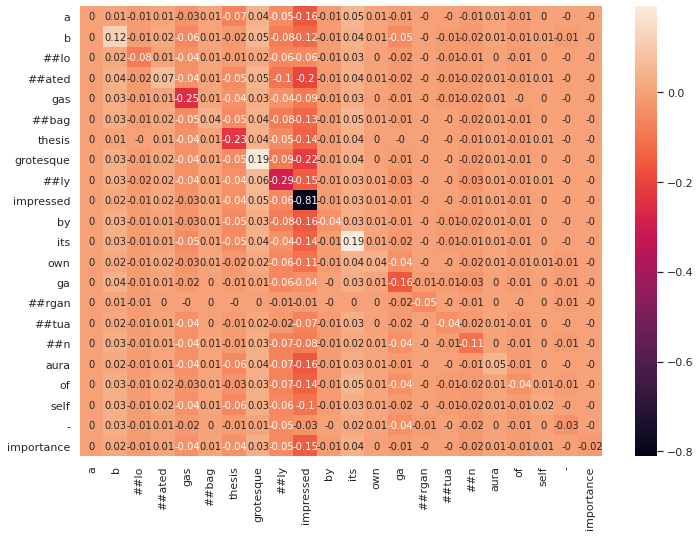

In [ ]:
# tok, emb = merge_bpe(tokens, embs.detach().numpy())
# tok, att = merge_bpe(tokens, atts)

Z = calc_Z(embs.detach().numpy())

data = Z * weights
data = data[1:-1, 1:-1]
g = sns.heatmap(np.around(data, 2), annot=True, annot_kws={"fontsize": 10}, fmt='g')
g.set_xticklabels(tokens[1:-1], rotation=90)
g.set_yticklabels(tokens[1:-1], rotation=0)
plt.show()

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
np.argmax(np.diagonal(data))

7

In [ ]:
def format_attention(attention, layers=None, heads=None):
    if layers:
        attention = [attention[layer_index] for layer_index in layers]
    squeezed = []
    for layer_attention in attention:
        # 1 x num_heads x seq_len x seq_len
        if len(layer_attention.shape) != 4:
            raise ValueError("The attention tensor does not have the correct number of dimensions. Make sure you set "
                             "output_attentions=True when initializing your model.")
        layer_attention = layer_attention.squeeze(0)
        if heads:
            layer_attention = layer_attention[heads]
        squeezed.append(layer_attention)
    # num_layers x num_heads x seq_len x seq_len
    return torch.stack(squeezed)